In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tensorboard.backend.event_processing import event_accumulator
import subprocess
import webbrowser
import os

In [2]:
def get_summary(save_path,prepend=""):
    ea = event_accumulator.EventAccumulator(save_path)
    if not os.path.exists(save_path):
        print("no save path found, returning empy dict...")
        return dict()
    ea.Reload()
    res = dict()
    for tag in ea.Tags()['scalars']:
        evs = ea.Scalars(tag)
        wall_time = [e.wall_time for e in evs]
        step = [e.step for e in evs]
        value = [e.value for e in evs]
        tag = prepend + tag
        res[tag] = value
        res[tag+"_step"] = step
        res[tag + "_wall_time"] = wall_time
    res[prepend + 'scalars'] = [prepend + t for t in ea.Tags()['scalars']]
    scalars = ea.Tags()['scalars']
    #print("> get_summary():%s*; got %i scalars %s" % (prepend, len(scalars), ", ".join(scalars)))

    drs = os.listdir(save_path)
    for d in drs:
        np = os.path.join(save_path, d)
        if os.path.isdir(np):
            res.update( get_summary(np, d+'/') )
    return res

In [3]:
logs = get_summary('C:\\Users\\ejer\\Desktop\\Skole\\Universitet\\02460ADVANCEDMACHINELEARNING\\Project\\DoomEnvir\\doomenvir\\gdoom\\Predict\\predicts6')

INFO:tensorflow:Directory watcher advancing from C:\Users\ejer\Desktop\Skole\Universitet\02460ADVANCEDMACHINELEARNING\Project\DoomEnvir\doomenvir\gdoom\Predict\predicts6\train_v2s6_lr=0.0001_bs=10_0\events.out.tfevents.1556454678.TOBIAS-PC to C:\Users\ejer\Desktop\Skole\Universitet\02460ADVANCEDMACHINELEARNING\Project\DoomEnvir\doomenvir\gdoom\Predict\predicts6\train_v2s6_lr=0.0001_bs=10_0\events.out.tfevents.1556964125.TOBIAS-PC
INFO:tensorflow:No path found after C:\Users\ejer\Desktop\Skole\Universitet\02460ADVANCEDMACHINELEARNING\Project\DoomEnvir\doomenvir\gdoom\Predict\predicts6\train_v2s6_lr=0.0001_bs=10_0\events.out.tfevents.1556964125.TOBIAS-PC
INFO:tensorflow:Directory watcher advancing from C:\Users\ejer\Desktop\Skole\Universitet\02460ADVANCEDMACHINELEARNING\Project\DoomEnvir\doomenvir\gdoom\Predict\predicts6\train_v2s6_lr=0.0001_bs=10_1\events.out.tfevents.1556454674.TOBIAS-PC to C:\Users\ejer\Desktop\Skole\Universitet\02460ADVANCEDMACHINELEARNING\Project\DoomEnvir\doomenvir

In [4]:
def smootherfunc(kills_0,smooth_factor):
    while (len(kills_0) % smooth_factor != 0):
        kills_0= kills_0[:-1]
    kills_0avg=np.mean(kills_0.reshape(-1, smooth_factor), axis=1)
    kills_0std=np.std(kills_0.reshape(-1, smooth_factor), axis=1)/np.sqrt(smooth_factor)
    return(kills_0avg,kills_0std)
# If the arrays dont have the same length then mean over the ones we have.
def clipfunction(kills_0,kills_1,kills_2,kills_3):
    length=[len(kills_0),len(kills_1),len(kills_2),len(kills_3)]
    minlen=np.min(length)
    #index_min = np.argmin(length)
    return(kills_0[0:minlen],kills_1[0:minlen],kills_2[0:minlen],kills_3[0:minlen])

def avgkilltimereward(path, smooth_factor):
    string2=(path.split('_0'))
    stringname={}
    for i in range(0,4):
        stringname[i]=string2[0]+'_'+str(i)
    print(stringname[0])
    kills_0 = np.asarray(logs[str(stringname[0])+'/Perf/Kills'])
    kills_1 = np.asarray(logs[str(stringname[1])+'/Perf/Kills'])
    kills_2 = np.asarray(logs[str(stringname[2])+'/Perf/Kills'])
    kills_3 = np.asarray(logs[str(stringname[3])+'/Perf/Kills'])
    timealive_0 = np.asarray(logs[str(stringname[0])+'/Perf/Length'])
    timealive_1 = np.asarray(logs[str(stringname[1])+'/Perf/Length'])
    timealive_2 = np.asarray(logs[str(stringname[2])+'/Perf/Length'])
    timealive_3 = np.asarray(logs[str(stringname[3])+'/Perf/Length'])
    
    reward_0 = np.asarray(logs[str(stringname[0])+'/Perf/Reward'])
    reward_1 = np.asarray(logs[str(stringname[1])+'/Perf/Reward'])
    reward_2 = np.asarray(logs[str(stringname[2])+'/Perf/Reward'])
    reward_3 = np.asarray(logs[str(stringname[3])+'/Perf/Reward'])
    
    # the total number of frames used to train:
    timealive=np.sum([timealive_0.sum(),timealive_1.sum(),timealive_2.sum(),timealive_3.sum()])
    episodemean=(timealive_0[-20:-1].mean()+timealive_1[-20:-1].mean()+timealive_2[-20:-1].mean()+timealive_3[-20:-1].mean())/4
    print('Number of frames rendered='+str(timealive))
    print('Average time alive per episode in last 100 episodes='+str(episodemean))
    
    [kills_0,kills_1,kills_2,kills_3]=clipfunction(kills_0,kills_1,kills_2,kills_3)
    [timealive_0,timealive_1,timealive_2,timealive_3]=clipfunction(timealive_0,timealive_1,timealive_2,timealive_3)
    [reward_0,reward_1,reward_2,reward_3]=clipfunction(reward_0,reward_1,reward_2,reward_3)
    
    
    timealivecum=np.sum([timealive_0.cumsum(),timealive_1.cumsum(),timealive_2.cumsum(),timealive_3.cumsum()],axis=0)
    
    [timealivecum,timealivecumstd]=smootherfunc(timealivecum,smooth_factor)
    
    
    killsavg=np.mean([kills_0,kills_1,kills_2,kills_3],axis=0)
    [killsavgsmoth,killsstd]=smootherfunc(killsavg,smooth_factor)
    
    timealiveavg=np.mean([timealive_0,timealive_1,timealive_2,timealive_3],axis=0)
    [timealiveavgsmoth,timealivestd]=smootherfunc(timealiveavg,smooth_factor)
    
    rewardavg=np.mean([reward_0,reward_1,reward_2,reward_3],axis=0)
    [rewardavgsmoth,rewardstd]=smootherfunc(rewardavg,smooth_factor)
    
    
    return(killsavgsmoth,killsstd,timealiveavgsmoth,timealivestd,timealivecum,rewardavgsmoth,rewardstd,)
    

In [9]:

# The smoothing factor 
smooth_factor=20
# Filepath of the folders which ends with : _0 , it fill load the rest of the agents, and average over them..
[kills10,kills10std,timealive10,timealive10std,frames10,reward10,reward10std]=avgkilltimereward('train_v2s6_lr=0.0001_bs=10_0',smooth_factor)
[kills20,kills20std,timealive20,timealive20std,frames20,reward20,reward20std]=avgkilltimereward('train_v2s6_lr=0.0001_bs=20_0',smooth_factor)
[kills30,kills30std,timealive30,timealive30std,frames30,reward30,reward30std]=avgkilltimereward('train_v2s6_lr=0.0001_bs=30_0',smooth_factor)
# so the output is the Kill, kill std. Time alive for each episode, std of that. The frames, and the reward and reward std.


train_v2s6_lr=0.0001_bs=10_0
Number of frames rendered=178431.80009937286
Average time alive per episode in last 100 episodes=19.32894744371113
train_v2s6_lr=0.0001_bs=20_0
Number of frames rendered=94828.19998073578
Average time alive per episode in last 100 episodes=18.413157839524118
train_v2s6_lr=0.0001_bs=30_0
Number of frames rendered=92875.99995231628
Average time alive per episode in last 100 episodes=18.663157889717503


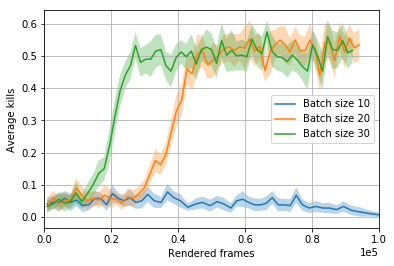

In [13]:

figure1=plt.figure()
#figsize=(6, 6)
plt.plot(frames10,kills10,label='Batch size 10')
plt.fill_between(frames10,kills10+2*kills10std,kills10-2*kills10std,alpha=0.3)
plt.plot(frames20,kills20,label='Batch size 20')
plt.fill_between(frames20,kills20+2*kills20std,kills20-2*kills20std,alpha=0.3)
plt.plot(frames30,kills30,label='Batch size 30')
plt.fill_between(frames30,kills30+2*kills30std,kills30-2*kills30std,alpha=0.3)
plt.ylabel('Average kills')
plt.xlabel('Rendered frames')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim([0,100000])
plt.legend()

plt.grid()

# Save the plot the next cell.

In [ ]:
figure1.savefig("predictpositionkills.pdf", bbox_inches='tight')